# Boundary value problems

## Shooting method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.optimize
import scipy.special

Found omega = 1.00001 pi, n = 0
Found omega = 2.00002 pi, n = 1
Found omega = 3.00003 pi, n = 2
Found omega = 4.00004 pi, n = 3
Found omega = 5.00005 pi, n = 4
Found omega = 6.00006 pi, n = 5


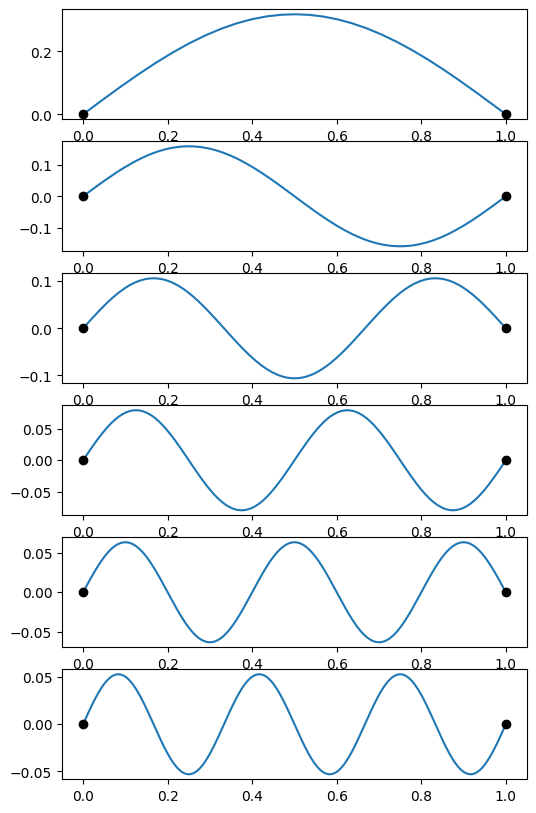

In [2]:
# First do the constant density string to check with the known frequencies
# and eigenfunctions

def derivs(x, y, omega):
    f, g = y
    dfdx = g
    density = 1
    dgdx = - omega**2 * density * f
    return dfdx, dgdx

def do_integration(omega):
    result = scipy.integrate.solve_ivp(derivs, (1e-5,1), (0,1), dense_output=True, args=(omega,), atol=1e-8, rtol=1e-8)
    return result.y[0,-1]

fig = plt.figure(figsize = (6,10))

oms = np.pi * np.array((1,2,3,4,5,6))
num = len(oms)

for i, om in enumerate(oms):
    omega = scipy.optimize.brentq(do_integration, 0.9*om, 1.1*om)
    
    result = scipy.integrate.solve_ivp(derivs, (1e-5,1), (0,1), dense_output=True, args=(omega,), atol=1e-8, rtol=1e-8)
    x = result.t
    f = result.y[0]

    # find the number of zero crossings (not including the endpoints)
    n = ((f[1:-1] * f[:-2]) < 0).sum()
    print("Found omega = %lg pi, n = %d" % (omega/np.pi,n))

    plt.subplot(num,1,1+i)
    plt.plot(x, f)
    plt.plot((0,1),(0,0), 'ko')

plt.show()

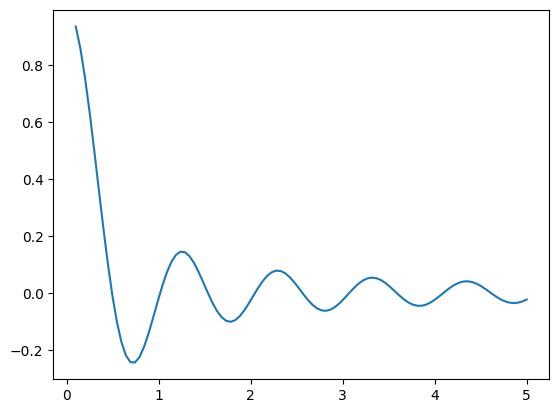

[0.44646465 0.99090909 1.48585859 2.03030303 2.52525253 3.06969697
 3.56464646 4.05959596 4.6040404 ]
Found omega = 0.493438 pi, n = 0
Found omega = 1.01755 pi, n = 1
Found omega = 1.53483 pi, n = 2
Found omega = 2.0489 pi, n = 3
Found omega = 2.56151 pi, n = 4
Found omega = 3.0735 pi, n = 5
Found omega = 3.58524 pi, n = 6
Found omega = 4.0969 pi, n = 7
Found omega = 4.60855 pi, n = 8


<Figure size 640x480 with 0 Axes>

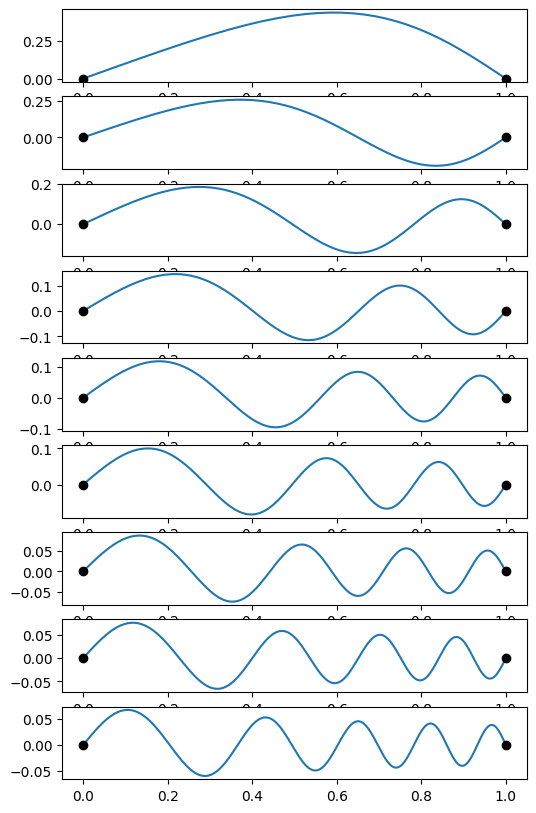

In [3]:
# Now do an x-dependent density

def derivs(x, y, omega):
    f, g = y
    dfdx = g
    density = 1 + 10*x**2
    dgdx = - omega**2 * density * f
    return dfdx, dgdx

def do_integration(omega):
    result = scipy.integrate.solve_ivp(derivs, (1e-5,1), (0,1), dense_output=True, args=(omega,), atol=1e-8, rtol=1e-8)
    return result.y[0,-1]

oms = np.pi * np.linspace(0.1,5,100)
result = np.array([do_integration(om) for om in oms]) 
plt.plot(oms/np.pi, result)
plt.show()
inds = np.where(np.diff(np.sign(result)))[0]
print(oms[inds]/np.pi)

plt.clf()
num = len(inds)
fig = plt.figure(figsize = (6,10))

for i, ind in enumerate(inds):
    omega = scipy.optimize.brentq(do_integration, oms[ind], oms[ind+1])

    result = scipy.integrate.solve_ivp(derivs, (1e-5,1), (0,1), dense_output=True, args=(omega,), atol=1e-8, rtol=1e-8)
    x = result.t
    f = result.y[0]

    # find the number of zero crossings (not including the endpoints)
    n = ((f[1:-1] * f[:-2]) < 0).sum()
    print("Found omega = %lg pi, n = %d" % (omega/np.pi,n))

    plt.subplot(num,1,1+i)
    plt.plot(x, f)
    plt.plot((0,1),(0,0), 'ko')

plt.show()

# Store the last eigenfunction we found to compare later with the relaxation result
x_s = x
f_s = f
om_s = omega


## Relaxation method

In [17]:
# Visualize matrices as a color map
def plot_matrices(A,titles=[]):
    n = len(A)
    if titles==[]:
        titles = [""]*n
    if n>4:
        nx = 4
    else:
        nx = n
    for j in range(int(np.floor(n/4))+1):        
        plt.clf()
        plt.figure(figsize=(nx*4,4))
        jmax = 4*(j+1)
        if jmax > n:
            jmax = n
        for i,AA in enumerate(A[4*j:jmax]):
            plt.subplot(1, nx, i+1)
            plt.imshow(AA)
            plt.colorbar()
            plt.title(titles[4*j + i])
        plt.show()

<Figure size 640x480 with 0 Axes>

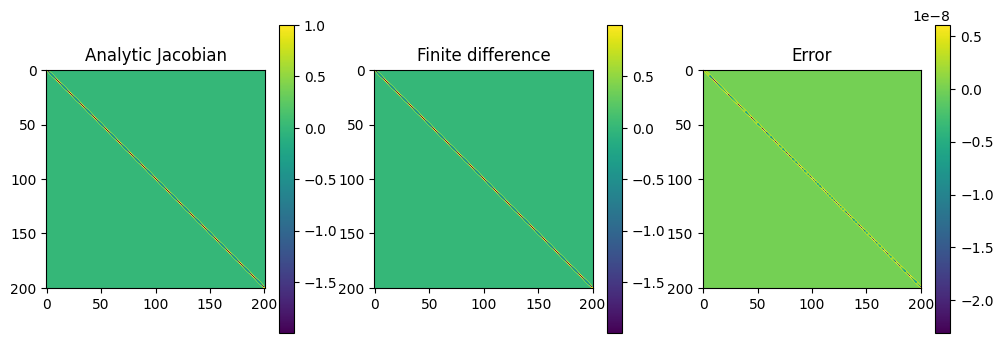

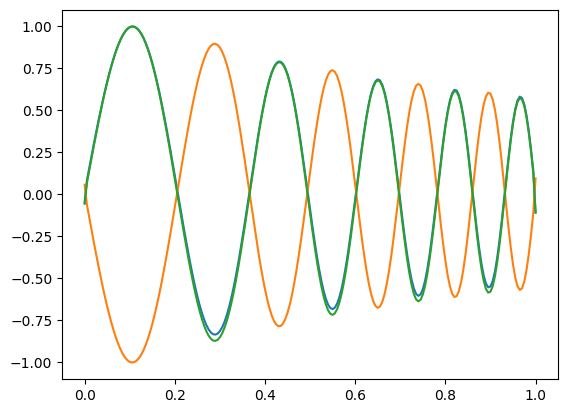

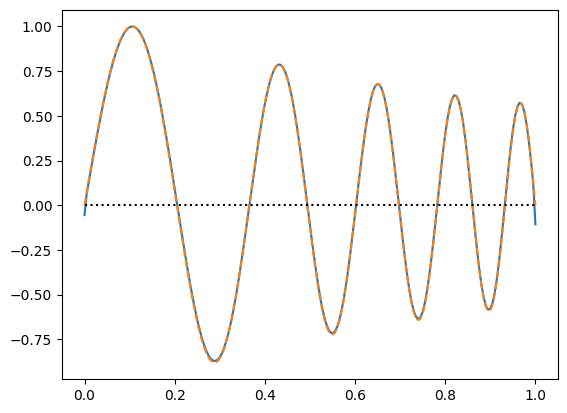

In [36]:
def rho(x):
    rho = 1.0 + 10*x**2
    #rho = np.ones_like(x)
    return rho

def calculate_G(f, x, omega):
    G = np.zeros(ngrid)
    dx = x[1]-x[0]  # assume constant spacing    
    G[1:-1] = f[2:] - (2 - dx**2 * omega**2 * rho(x[1:-1]))*f[1:-1] + f[:-2]
    G[0] = f[0]
    G[-1] = f[-1]
    return G

def calculate_J(f, x, omega, analytic = True):
    if analytic:
        return calculate_J_analytic(f, x, omega)
    else:
        return calculate_J_finite(f, x, omega)

def calculate_J_analytic(f, x, omega):
    dx = x[1]-x[0]  # assume constant spacing
    J = np.diag( - (2 - dx**2 * omega**2 * rho(x)), k=0)
    J = J + np.diag(np.ones(ngrid-1),k=1) + np.diag(np.ones(ngrid-1),k=-1)
    # boundary conditions
    J[0,0] = 1
    J[1,0] = 0
    J[-1,-1] = 1
    J[-2,-1] = 0
    return J

def calculate_J_finite(f, x, omega):
    # Jacobian from finite differences
    eps = 1e-8
    J = np.zeros((ngrid, ngrid))
    G1 = calculate_G(f, x, omega)
    for j in range(ngrid):
        f1 = np.copy(f)
        df = max(f[i]*eps,eps)
        f1[j] = f[j] + df
        G2 = calculate_G(f1, x, omega)
        J[j,:] = (G2-G1)/df
    return J

# Use the frequency from the shooting method:
omega = om_s
ngrid = 201
x = np.linspace(0,1,ngrid)

# Initial guess
f = np.ones_like(x)
plt.plot(x, f)

niter = 3
for m in range(niter):
    
    G = calculate_G(f, x, omega)
    J1 = calculate_J(f, x, omega, analytic = True)
    J2 = calculate_J(f, x, omega, analytic = False)
    if m == 0:
        # as a check on the first time through compare the 
        # analytic and finite difference Jacobians
        plot_matrices([J1,J2, J1-J2],
                      titles=["Analytic Jacobian","Finite difference","Error"])
    f = f + np.linalg.inv(J1)@G
    
    f = f / max(np.abs(f))
    plt.plot(x, f)
    
plt.show()

plt.clf()
plt.plot(x,f)
# compare with the analytic solution for constant density:
#plt.plot(x, np.sin(5 * np.pi * x), ":")
# compare with the shooting result:
plt.plot(x_s, f_s * max(f)/max(f_s), "--")
plt.plot((0,1),(0,0),"k:")
plt.show()